# Shortest Path in a Graph with Genetic Algorithms

Load of the libraries needed

In [183]:
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

Setting an exaple Graph to test the code

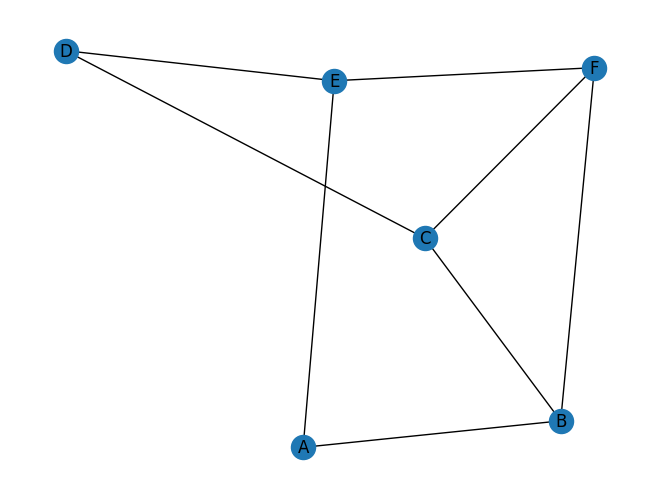

In [184]:
# Creamos un grafo no dirigido
G = nx.Graph()

# Agregamos nodos
nodes_simple = ["A", "B", "C", "D", "E", 'F']
G.add_nodes_from(nodes_simple)

# Agregamos aristas ponderadas
G.add_edge("A", "B", weight=5)
G.add_edge("B", "C", weight=7)
G.add_edge("C", "D", weight=3)
G.add_edge("D", "E", weight=2)
G.add_edge("E", "A", weight=4)
G.add_edge("E", "F", weight=6)
G.add_edge("B", "F", weight=2)
G.add_edge("C", "F", weight=4)


nx.draw(G, with_labels=True)

In [185]:
Adjacency = nx.adjacency_matrix(G).todense()
Adjacency =np.where(Adjacency == 0, np.inf, Adjacency)
print(Adjacency)

Chromosome = len(Adjacency)

[[inf  5. inf inf  4. inf]
 [ 5. inf  7. inf inf  2.]
 [inf  7. inf  3. inf  4.]
 [inf inf  3. inf  2. inf]
 [ 4. inf inf  2. inf  6.]
 [inf  2.  4. inf  6. inf]]


In [186]:
class GeneticAlgorithm:
    def __init__(self, Npop, Nit, nodes, max_length, Adjacency, start_node, end_node):
        # Number of chromosomes
        self.Npop = Npop  
        # Number of iterations
        self.Nit = Nit  
        # List of nodes in the graph 
        self.nodes = nodes 
        # Maximum chromosome length
        self.max_length = max_length  
        # Graph adjacency matrix
        self.Adjacency = np.array(Adjacency)  
        # Fixed start node
        self.start_node = start_node  
        # Fixed end node
        self.end_node = end_node  
        # Initialize population with random chromosomes
        self.population = [self.random_chromosome() for _ in range(Npop)]

    def random_chromosome(self):
        # Ensure a small chance of generating a chromosome with only start and end nodes
        if random.random() < 0.1:  
            return [self.start_node, self.end_node]
        # Generate a random chromosome with intermediate nodes
        length = random.randint(1, self.max_length - 2)  
        middle_nodes = [random.randint(0, len(self.Adjacency) - 1) for _ in range(length)]
        return [self.start_node] + middle_nodes + [self.end_node]

    def crossover(self, parent1, parent2):
        # Determine the minimum length of parent chromosomes
        min_len = min(len(parent1), len(parent2)) - 2
        if min_len < 1:
            # If parents are too short, return copies of them
            return parent1[:], parent2[:] 

        # Perform crossover at a random point
        crossover_point = random.randint(1, min_len)
        # Create two children by exchanging parts of parents' chromosomes
        child1 = [self.start_node] + parent1[1:crossover_point+1] + parent2[crossover_point+1:-1] + [self.end_node]
        child2 = [self.start_node] + parent2[1:crossover_point+1] + parent1[crossover_point+1:-1] + [self.end_node]
        return child1, child2

    def mutate(self, chromosome):
        # Ensure the chromosome has enough length for mutation
        if len(chromosome) > 2:  
            # Randomly select mutation type: insert, delete, or change
            mutation_type = random.choice(['insert', 'delete', 'change'])
            # Randomly select position for mutation
            position = random.randint(1, len(chromosome) - 2)  
            if mutation_type == 'insert' and len(chromosome) < self.max_length:
                # Insert a random node at the chosen position
                node = random.randint(0, len(self.Adjacency) - 1)
                chromosome.insert(position, node)
            elif mutation_type == 'delete' and len(chromosome) > 3:
                # Delete a node at the chosen position
                chromosome.pop(position)
            elif mutation_type == 'change':
                # Change the node value at the chosen position
                node = random.randint(0, len(self.Adjacency) - 1)
                chromosome[position] = node

    def fitness(self, chromosome):
        # Calculate the total cost of the given chromosome
        total_cost = 0
        for i in range(len(chromosome) - 1):
            cost = self.Adjacency[chromosome[i], chromosome[i + 1]]
            # If cost is infinite, return infinity indicating infeasible solution
            if cost == np.inf:
                return np.inf  
            total_cost += cost
        return total_cost

    def select(self, population, fitness_scores):
        # Convert fitness scores to numpy array for efficient operations
        fitness_scores = np.array(fitness_scores)

        # If all chromosomes have infinite fitness scores, generate a new population
        if np.all(np.isinf(fitness_scores)):
            return [self.random_chromosome() for _ in range(self.Npop)] 

        # Calculate selection probabilities based on fitness scores
        probabilities = 1 / (fitness_scores + 1e-6)
        probabilities[np.isinf(fitness_scores)] = 0  
        
        total_probability = np.sum(probabilities)
        if total_probability > 0:
            probabilities /= total_probability
        else:
            probabilities = np.ones_like(fitness_scores) / len(fitness_scores)
        
        # Select new population by roulette wheel selection
        selected_indices = np.random.choice(len(population), size=self.Npop, replace=True, p=probabilities)
        return [population[i] for i in selected_indices]

    def evolve(self):
        # Execute genetic algorithm for a given number of iterations
        for _ in range(self.Nit):
            # Calculate fitness scores for current population
            fitness_scores = [self.fitness(chrom) for chrom in self.population]
            # Select new population based on fitness scores
            self.population = self.select(self.population, fitness_scores)
            new_population = []
            # Generate new population through crossover and mutation
            while len(new_population) < self.Npop:
                parent1, parent2 = random.sample(self.population, 2)
                child1, child2 = self.crossover(parent1, parent2)
                self.mutate(child1)
                self.mutate(child2)
                new_population.extend([child1, child2])

            # Update population with new generation
            self.population = new_population[:self.Npop]
            
    def answer(self, chrom):
        # Print the stations to take for the given chromosome
        stations = [self.nodes[node] for node in chrom]
        print('Stations to take:', stations)

    def run(self):
        # Run the genetic algorithm and print the best solution found
        self.evolve()
        final_fitness = [self.fitness(chrom) for chrom in self.population]
        best_index = np.argmin(final_fitness)
        best_chromosome = self.population[best_index]
        best_fitness = final_fitness[best_index]
        
        # If the best fitness is infinity, run the algorithm again
        if best_fitness == np.inf:
            self.run()
        else:
            print("Best chromosome:", best_chromosome)
            print("Best fitness (path cost):", best_fitness)
            # Print the stations to take for the best chromosome
            self.answer(best_chromosome)


### Example 1

In [187]:

ga = GeneticAlgorithm(Npop=100, Nit=50, nodes=nodes_simple, max_length=len(Adjacency), Adjacency=Adjacency, start_node=0, end_node=4)
ga.run()


Best chromosome: [0, 4]
Best fitness (path cost): 4.0
Stations to take: ['A', 'E']


### Example 2

In [188]:
ga = GeneticAlgorithm(Npop=100, Nit=50, nodes=nodes_simple, max_length=len(Adjacency), Adjacency=Adjacency, start_node=3, end_node=5)
ga.run()

Best chromosome: [3, 2, 5]
Best fitness (path cost): 7.0
Stations to take: ['D', 'C', 'F']


## Representing the Mexico City Subway 

{'El Rosario': Text(0.5304361761662242, 0.7347214725756886, 'El Rosario'),
 'Politécnico': Text(-0.02451419906155592, 0.6716820819953888, 'Politécnico'),
 'Petroleo': Text(-0.061075118112312664, 0.5916787786404252, 'Petroleo'),
 'Deportivo': Text(-0.2285821858735213, 0.5755414082319398, 'Deportivo'),
 'Indios Verdes': Text(-0.2565972806143817, 0.6602897412309109, 'Indios Verdes'),
 'Martín Carrera': Text(-0.4126687813978917, 0.5141670824855327, 'Martín Carrera'),
 '4 Caminos': Text(0.7588074132109879, 0.37586978696258627, '4 Caminos'),
 'Tacuba': Text(0.6755703086364397, 0.35662424066135207, 'Tacuba'),
 'La Raza': Text(-0.1306523960159448, 0.41885333285181364, 'La Raza'),
 'Consulado': Text(-0.4011660979131111, 0.23370953590182716, 'Consulado'),
 'Oceania': Text(-0.6301613682241656, 0.10073327417200244, 'Oceania'),
 'Ciudad Azteca': Text(-0.8954150265731637, 0.19585829755053677, 'Ciudad Azteca'),
 'Guerrero': Text(-0.012273189748224713, 0.2649295489687131, 'Guerrero'),
 'Garibaldi': Te

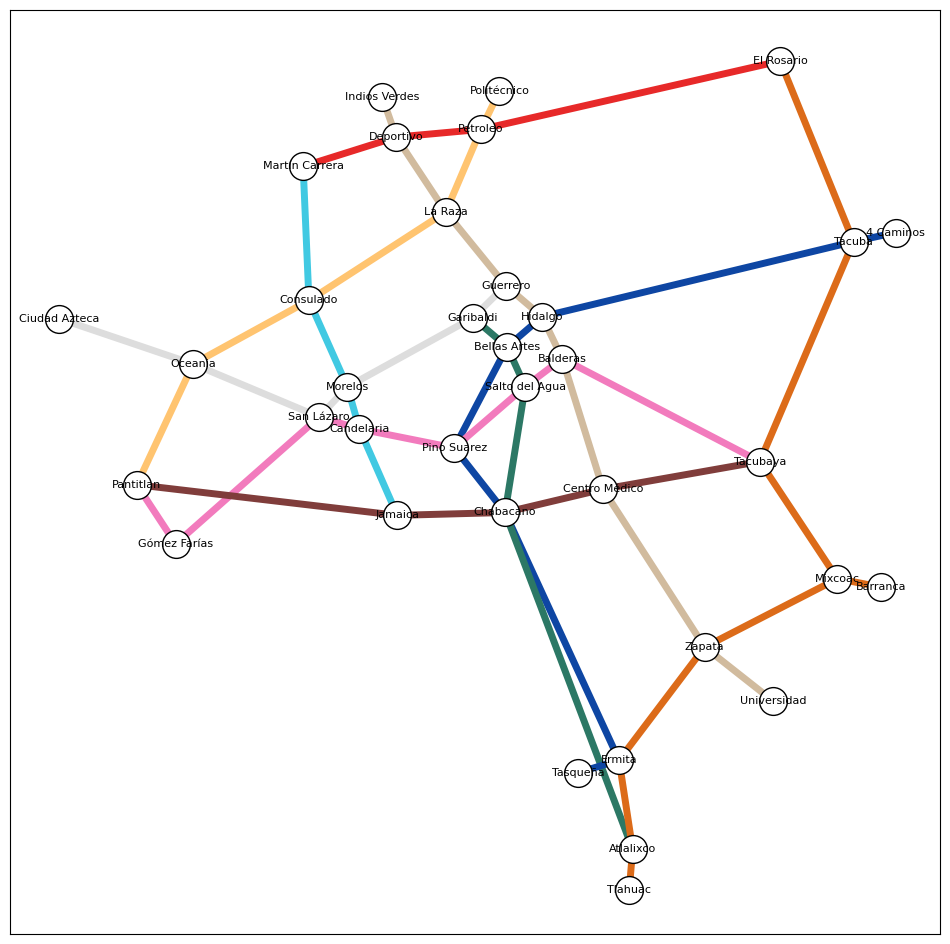

In [189]:
S = nx.Graph()

nodes = ['El Rosario', 'Politécnico', 'Petroleo', 'Deportivo', 'Indios Verdes', 'Martín Carrera',
                                       '4 Caminos', 'Tacuba', 'La Raza', 'Consulado', 'Oceania', 'Ciudad Azteca', 'Guerrero', 
                                       'Garibaldi', 'Morelos', 'Hidalgo', 'Bellas Artes', 'Balderas', 'Salto del Agua', 'Pino Suarez',
                                       'Candelaria', 'San Lázaro', 'Gómez Farías', 'Pantitlan', 'Tacubaya', 'Centro Médico', 'Chabacano',
                                       'Jamaica', 'Mixcoac', 'Zapata', 'Ermita', 'Atlalixco', 'Barranca', 'Universidad', 'Tasqueña',
                                       'Tlahuac']

edges = [
    #Linea 7 naranja
    ("El Rosario", "Tacuba", {"weight": 4, "color": "#DC6B19"}),
    ('Tacuba', 'Tacubaya',{'weight':5, 'color':"#DC6B19"}),
    ('Tacubaya', 'Mixcoac',{'weight':3, 'color':"#DC6B19"}),
    ('Mixcoac', 'Barranca',{'weight':1, 'color':"#DC6B19"}),
    
    #linea 6 Rojo
    ("El Rosario", "Petroleo", {"weight": 6, "color": "#E72929"}),
    ("Petroleo", "Deportivo", {"weight": 2, "color": "#E72929"}),
    ("Deportivo", "Martín Carrera", {"weight": 2, "color": "#E72929"}),
    ("Deportivo", "Martín Carrera", {"weight": 2, "color": "#E72929"}),
    
    #Linea 2 Azul
    ("4 Caminos", "Tacuba", {"weight": 1, "color": "#0E46A3"}),
    ('Tacuba', 'Hidalgo',{'weight':7, 'color':"#0E46A3"}),
    ('Hidalgo', 'Bellas Artes',{'weight':1, 'color':"#0E46A3"}),
    ('Bellas Artes','Pino Suarez',{'weight':3, 'color':"#0E46A3"}),
    ('Pino Suarez','Chabacano',{'weight':2, 'color':"#0E46A3"}),
    ('Chabacano','Ermita',{'weight':6, 'color':"#0E46A3"}),
    ('Ermita','Tasqueña',{'weight':1, 'color':"#0E46A3"}),
    
    #Linea 1 Rosa
    ('Tacubaya','Balderas',{'weight':6, 'color':"#F27BBD"}),
    ('Balderas','Salto del Agua',{'weight':1, 'color':"#F27BBD"}),
    ('Salto del Agua','Pino Suarez',{'weight':2, 'color':"#F27BBD"}),
    ('Pino Suarez','Candelaria',{'weight':2, 'color':"#F27BBD"}),
    ('Candelaria','San Lázaro',{'weight':1, 'color':"#F27BBD"}),
    ('San Lázaro','Gómez Farías',{'weight':4, 'color':"#F27BBD"}),
    ('Gómez Farías','Pantitlan',{'weight':2, 'color':"#F27BBD"}),
    
    #linea 9 Cafe
    ('Tacubaya','Centro Médico',{'weight':3, 'color':"#803D3B"}),
    ('Centro Médico','Chabacano',{'weight':2, 'color':"#803D3B"}),
    ('Chabacano','Jamaica',{'weight':2, 'color':"#803D3B"}),
    ('Jamaica','Pantitlan',{'weight':5, 'color':"#803D3B"}),
    
    #Linea 5 Amarillo 
    ('Politécnico','Petroleo',{'weight':1, 'color':"#FFC470"}),
    ('Petroleo','La Raza',{'weight':2, 'color':"#FFC470"}),
    ('La Raza','Consulado',{'weight':3, 'color':"#FFC470"}),
    ('Consulado','Oceania',{'weight':3, 'color':"#FFC470"}),
    ('Oceania','Pantitlan',{'weight':3, 'color':"#FFC470"}),
    
    #linea 3 cafe claro
    ("Indios Verdes", "Deportivo", {"weight": 1, "color": "#D1BB9E"}),
    ("Deportivo", 'La Raza',{"weight": 2, "color": "#D1BB9E"}),
    ('La Raza','Guerrero',{"weight": 2, "color": "#D1BB9E"}),
    ('Guerrero','Hidalgo',{"weight": 1, "color": "#D1BB9E"}),
    ('Hidalgo','Balderas',{"weight": 1, "color": "#D1BB9E"}),
    ('Balderas','Centro Médico',{"weight": 3, "color": "#D1BB9E"}),
    ('Centro Médico','Zapata',{"weight": 4, "color": "#D1BB9E"}),
    ('Zapata','Universidad',{"weight": 2, "color": "#D1BB9E"}),
    
    #Linea 12 Mostaza
    ('Mixcoac', 'Zapata',{'weight':3, 'color':"#DC6B19"}),
    ('Zapata','Ermita',{'weight':3, 'color':"#DC6B19"}),
    ('Ermita','Atlalixco',{'weight':2, 'color':"#DC6B19"}),
    ('Atlalixco','Tlahuac',{'weight':1, 'color':"#DC6B19"}),
    
    #Linea 8 Verde
    ('Garibaldi', 'Bellas Artes',{'weight':1, 'color':"#2C7865"}),
    ('Bellas Artes','Salto del Agua',{'weight':1, 'color':"#2C7865"}),
    ('Salto del Agua','Chabacano',{'weight':3, 'color':"#2C7865"}),
    ('Chabacano','Atlalixco',{'weight':8, 'color':"#2C7865"}),
    
    #linea 4 Cyan
    ("Martín Carrera",'Consulado',{"weight": 3, "color": "#41C9E2"}),
    ('Consulado','Morelos',{"weight": 2, "color": "#41C9E2"}),
    ('Morelos','Candelaria',{"weight": 1, "color": "#41C9E2"}),
    ('Candelaria','Jamaica',{"weight": 2, "color": "#41C9E2"}),
    
    #linea B Gris
    ('Guerrero','Garibaldi',{"weight": 1, "color": "#DDDDDD"}),
    ('Garibaldi','Morelos',{"weight": 3, "color": "#DDDDDD"}),
    ('Morelos','San Lázaro',{"weight": 1, "color": "#DDDDDD"}),
    ('San Lázaro','Oceania',{"weight": 3, "color": "#DDDDDD"}),
    ('Oceania','Ciudad Azteca',{"weight": 3, "color": "#DDDDDD"}),
    ]
    
    
S.add_nodes_from(nodes)
S.add_edges_from(edges)

pos = nx.kamada_kawai_layout(S)

node_size = 400
font_size = 8
edge_width = 5
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(S, pos, node_size=node_size, node_color='white', edgecolors='black', linewidths=1)
for u, v, data in S.edges(data=True):
    nx.draw_networkx_edges(S, pos, edgelist=[(u, v)], edge_color=data['color'], width=edge_width)
nx.draw_networkx_labels(S, pos, font_size=font_size, font_color='black')



In [190]:
Subway_Adjacency = nx.adjacency_matrix(S).todense()
Subway_Adjacency =np.where(Subway_Adjacency == 0, np.inf, Subway_Adjacency)
print(Subway_Adjacency)

[[inf inf  6. ... inf inf inf]
 [inf inf  1. ... inf inf inf]
 [ 6.  1. inf ... inf inf inf]
 ...
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]]


## Aplication of the Algorithm

In [194]:
subway = GeneticAlgorithm(Npop=1000, Nit=500, nodes=nodes, 
                          max_length=len(Subway_Adjacency)/2, Adjacency=Subway_Adjacency, 
                          start_node=0, end_node=21)
subway.run()

Best chromosome: [0, 2, 8, 9, 14, 21]
Best fitness (path cost): 14.0
Stations to take: ['El Rosario', 'Petroleo', 'La Raza', 'Consulado', 'Morelos', 'San Lázaro']
